## MARVEL MOVIES IN ORDER

- Iron Man (2008)
- The Incredible Hulk (2008)
- Iron Man 2 (2010)
- Thor (2011) ---------------NOT DONE
- Captain America: The First Avenger (2011)  -------------NOT DONE
- The Avengers (2012)
- Iron Man 3 (2013)
- Thor: The Dark World (2013)
- Captain America: The Winter Soldier (2014)
- Guardians of the Galaxy (2014)
- Avengers: Age of Ultron (2015)
- Ant-Man (2015)
- Captain America: Civil War (2016)
- Doctor Strange (2016)
- Guardians of the Galaxy Vol. 2 (2017)
- Spider-Man: Homecoming (2017)
- Thor: Ragnarok (2017) ---- not in correct format 
- Black Panther (2017) ---- not in correct format
- Avengers: Infinity War (2018)
- Ant-Man and the Wasp (2018) ---- not in correct format
- Captain Marvel (2019)
- Avengers: Endgame (2019) ---- SCRAPED TILL PHASE 2
- Spider-Man: Far From Home (2019)
- Black Widow (2021)
- Shang-Chi and the Legend of the Ten Rings (2021)
- Eternals (2021)
- Spider-Man: No Way Home (2021)
- Doctor Strange in the Multiverse of Madness (2022)
- Thor: Love and Thunder (2022)
- Black Panther: Wakanda Forever (2022)
- Ant-Man and the Wasp: Quantumania (2023)
- Guardians of the Galaxy Vol. 3 (2023)
- The Marvels (2023)


In [1]:
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [56]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import re
import string
import operator
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [61]:
print(transformers.__version__)
seed = 38
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\n')
print(device)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

4.39.1


cpu


In [10]:
train_data = "sentiment_Data/train.txt"
test_data = "sentiment_Data/test.txt"
val_data = "sentiment_Data/val.txt"

In [50]:
dict = {"surprise": 0, "love": 1, "joy": 2, "fear": 3, "anger": 4, "sadness": 5}
def convert_txt_to_cvs(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    sentences = []
    labels = []
    for line in tqdm(lines):
        sentence, label = line.split(';')
        sentences.append(sentence)
        labels.append(dict[label[:-1]])
    return sentences, labels

In [51]:
# make the data csv

train_sentences, train_labels = convert_txt_to_cvs(train_data)
test_sentences, test_labels = convert_txt_to_cvs(test_data)
val_sentences, val_labels = convert_txt_to_cvs(val_data)

train_df = pd.DataFrame({'text': train_sentences, 'label': train_labels})
test_df = pd.DataFrame({'text': test_sentences, 'label': test_labels})
val_df = pd.DataFrame({'text': val_sentences, 'label': val_labels})

print(train_df.head())

100%|██████████| 2000/2000 [00:00<00:00, 250010.67it/s]

                                                text  label
0                            i didnt feel humiliated      5
1  i can go from feeling so hopeless to so damned...      5
2   im grabbing a minute to post i feel greedy wrong      4
3  i am ever feeling nostalgic about the fireplac...      1
4                               i am feeling grouchy      4


## Preprocessing the data

In [52]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop = stopwords.words('english')

df_train = train_df
df_test = test_df
df_val = val_df
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print(df_train.shape, df_test.shape, df_val.shape)
print('\n')
df_val['pre_text'] = df_val['text'].str.lower()
df_val['pre_text'] = df_val['text'].str.replace(r'[^\w\s]+', '')
df_val['pre_text'] = df_val['text'].str.replace('<br />','')
df_val['pre_text'] = df_val['text'].str.replace('<br />','')
df_val['pre_text'] = df_val['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df_train['pre_text'] = df_train['text'].str.lower()
df_train['pre_text'] = df_train['text'].str.replace(r'[^\w\s]+', '')
df_train['pre_text'] = df_train['text'].str.replace('<br />','')
df_train['pre_text'] = df_train['text'].str.replace('<br />','')
df_train['pre_text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print('Text Pre-Processing Finish!')

df_val['text'] = df_val['pre_text']
df_train['text'] = df_train['pre_text']

print(df_train.shape, df_test.shape, df_val.shape)
content = df_train['text'].values
labels = df_train['label'].values

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vartika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(16000, 2) (2000, 2) (2000, 2)


Text Pre-Processing Finish!
(16000, 3) (2000, 2) (2000, 3)


In [53]:
def encoding_process(_content):
    get_ids = []    
    for text in _content:
        input_ids = tokenizer.encode(
                        text,                      
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True, 
                        return_tensors = 'pt')
        get_ids.append(input_ids)    
    
    get_ids = torch.cat(get_ids, dim=0)
    return get_ids
# make sure return_dict is not default
return_dict = False

# Training dataset 
content = df_train['text'].values
labels = df_train['label'].values
get_ids = encoding_process(content)
# make labels float tensor
print(labels)
labels = torch.tensor(labels)

# Validation dataset
val_content = df_val['text'].values
val_labels = df_val['label'].values
val_get_ids = encoding_process(val_content)
val_labels = torch.tensor(val_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Vartika\anaconda3\envs\dl\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[5 5 4 ... 2 4 5]


In [71]:
train_dataloader = DataLoader(TensorDataset(get_ids, labels), batch_size=2, shuffle=True)
val_dataloader = DataLoader(TensorDataset(val_get_ids, val_labels), batch_size=2, shuffle=True)
test_dataloader = DataLoader(TensorDataset(val_get_ids, val_labels), batch_size=2, shuffle=True)
epochs = 5

In [75]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, output_attentions=False, output_hidden_states=False)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
output_model = 'finetuned_BERT_epoch_5.pth'
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# save
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

# reference
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

def accuracy_calc(preds, labels):
    
    pre = np.argmax(preds, axis=1).flatten()
    real = labels.flatten()
    return accuracy_score(real, pre)

def f1_accuracy(preds, labels):
    pre = np.argmax(preds, axis=1).flatten()
    real = labels.flatten()
    return f1_score(real, pre, average='weighted')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
def train_data(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, total_val_loss = 0, 0
        total_eval_accuracy = 0
        _f1 = 0
        _train_f1 = 0
        for b in tqdm(train_dataloader):
            batch = b
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            model.zero_grad()
            loss, train_ = model(inputs, token_type_ids=None, attention_mask=(inputs>0).to(device), labels=labels, return_dict = False)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            _train_f1 += f1_accuracy(train_.detach().cpu().numpy(), labels.to('cpu').numpy())

            
        model.eval()
        for b in tqdm(val_dataloader):
            batch = b
            with torch.no_grad():
                loss, val_ = model(batch[0].to(device), token_type_ids=None, attention_mask=(batch[0]>0).to(device), labels=batch[1].to(device),return_dict = False)
                    
                total_val_loss += loss.item()
                
                val_ = val_.detach().cpu().numpy()
                label_ids = batch[1].to('cpu').numpy()
                total_eval_accuracy += accuracy_calc(val_, label_ids)
                _f1 += f1_accuracy(val_, label_ids)
        
        training_loss = total_loss / len(train_dataloader)
        valid_loss = total_val_loss / len(val_dataloader)
        _accuracy = total_eval_accuracy / len(val_dataloader)
        _f1_score = _f1 / len(val_dataloader)
        train_f1_score = _train_f1/ len(train_dataloader)
        
        print('Training loss is', training_loss)
        print('Valid loss is:', valid_loss)
        print('Acc score is:', _accuracy)
        print('F1_score is:', _f1_score)
        print('train_F1_score is:', train_f1_score)
        print('\n')

save(model, optimizer)

# ----------------SENTIMENT ANALYSIS---------------

In [40]:
def process_the_script(important_chars,txt_path):
    important_chars = ['tony stark','pepper potts','rhodey','aldrich killian','maya hansen','ellen brandt','eric savin','mathew ellis','happy hogan','trevor slattery','jarvis','extras','bruce banner']
    all_dialogues = []
    char_dialogues = {}
    with open(txt_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if ":" in line:
                speaker = line.split(":")[0].lower()

                if " ".join(speaker.split(" ")[:2]) in important_chars:
                    if " ".join(speaker.split(" ")[:2]) not in char_dialogues:
                        char_dialogues[" ".join(speaker.split(" ")[:2])] = []
                    char_dialogues[" ".join(speaker.split(" ")[:2])].append(line.split(":")[1].strip())
                    all_dialogues.append(line.split(":")[1].strip())
                else:
                    if "extras" not in char_dialogues:
                        char_dialogues["extras"] = []
                    char_dialogues["extras"].append(line.split(":")[1].strip())
                    all_dialogues.append(line.split(":")[1].strip())

    print("Length of all dialogues:", len(all_dialogues))
    total_len = 0
    print("Length of dialogues for each character:")
    for char in char_dialogues:
        total_len += len(char_dialogues[char])
        print(char, len(char_dialogues[char]))

    print("Total length of dialogues:", total_len)
    return char_dialogues, all_dialogues

NLTK Vader Sentiment Analysis


In [39]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')# Compute sentiment labels

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vartika\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [47]:
def compute_sentiment_labels(dialogues):
    sid = SentimentIntensityAnalyzer()
    sentiment_labels = []
    for dialogue in dialogues:
        sentiment_labels.append(sid.polarity_scores(dialogue)['compound'])
    return sentiment_labels

def plot_sentiment_distribution(sent_dicts):
    pos_counts = {}
    neg_counts = {}
    neu_counts = {}

    for char in sent_dicts:
        pos_counts[char] = 0
        neg_counts[char] = 0
        neu_counts[char] = 0
        for sent in sent_dicts[char]:
            if sent >= 0.05:
                pos_counts[char] += 1
            elif sent <= -0.05:
                neg_counts[char] += 1
            else:
                neu_counts[char] += 1
    # plot graph for sentiment analysis
    import matplotlib.pyplot as plt
    import numpy as np

    chars = list(pos_counts.keys())
    pos = list(pos_counts.values())
    neg = list(neg_counts.values())
    neu = list(neu_counts.values())

    x = np.arange(len(chars))
    fig, ax = plt.subplots()
    bar_width = 0.2
    b1 = ax.bar(x, pos, width=bar_width, label='Number of Positive Dialogues')
    b2 = ax.bar(x + bar_width, neg, width=bar_width, label='Number of Negative Dialogues')
    b3 = ax.bar(x + 2*bar_width, neu, width=bar_width, label='Number of Neutral Dialogues')

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(chars, rotation=90)
    ax.legend()
    plt.show()
    total = {}
    for char in sent_dicts:
        total[char] = pos_counts[char] + neg_counts[char] + neu_counts[char]
    pos_perc = {}
    neg_perc = {}
    neu_perc = {}
    for char in sent_dicts:
        pos_perc[char] = pos_counts[char] / total[char]
        neg_perc[char] = neg_counts[char] / total[char]
        neu_perc[char] = neu_counts[char] / total[char]

    # plot graph for sentiment analysis
    import matplotlib.pyplot as plt
    import numpy as np

    chars = list(pos_perc.keys())
    pos = list(pos_perc.values())
    neg = list(neg_perc.values())
    neu = list(neu_perc.values())

    x = np.arange(len(chars))
    fig, ax = plt.subplots()
    bar_width = 0.2
    b1 = ax.bar(x, pos, width=bar_width, label='Percent of Positive Dialogues')
    b2 = ax.bar(x + bar_width, neg, width=bar_width, label='Percent of Negative Dialogues')
    b3 = ax.bar(x + 2*bar_width, neu, width=bar_width, label='Percent of Neutral Dialogues')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(chars, rotation=90)
    ax.legend()
    plt.show()


### Iron man 1 (2008)

Length of all dialogues: 903
Length of dialogues for each character:
tony stark 371
extras 369
happy hogan 1
jarvis 36
pepper potts 126
Total length of dialogues: 903


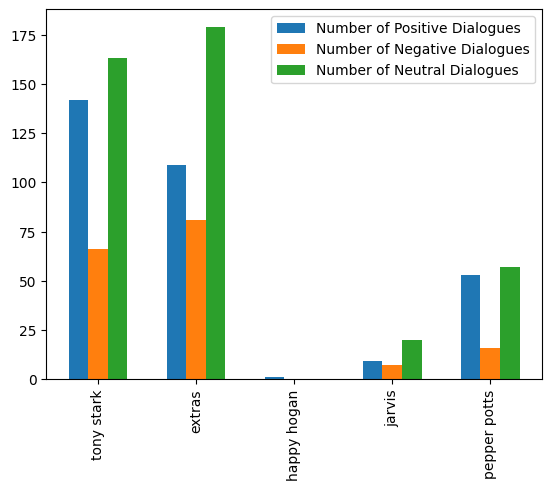

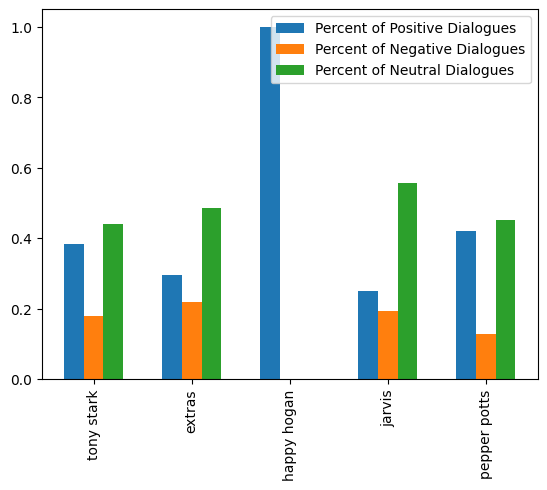

In [51]:
read_data = "Iron Man.txt"
important_chars = ['tony stark','pepper potts','obadiah stane','christine everhart','james rhodes','ho yinsen','jarvis','phil coulson','nick fury','howard stark','extras','happy hogan']
char_dialogues, all_dialogues = process_the_script(important_chars,read_data)
sent_dicts = {}
for char in char_dialogues:
    sent_dicts[char] = compute_sentiment_labels(char_dialogues[char])
plot_sentiment_distribution(sent_dicts)


## Iron man 3

Length of all dialogues: 1043
Length of dialogues for each character:
tony stark 400
happy hogan 56
extras 245
maya hansen 65
aldrich killian 66
jarvis 45
pepper potts 94
rhodey 48
trevor slattery 17
bruce banner 7
Total length of dialogues: 1043


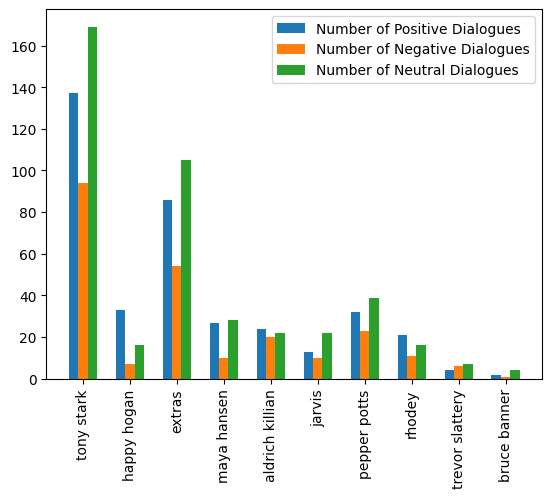

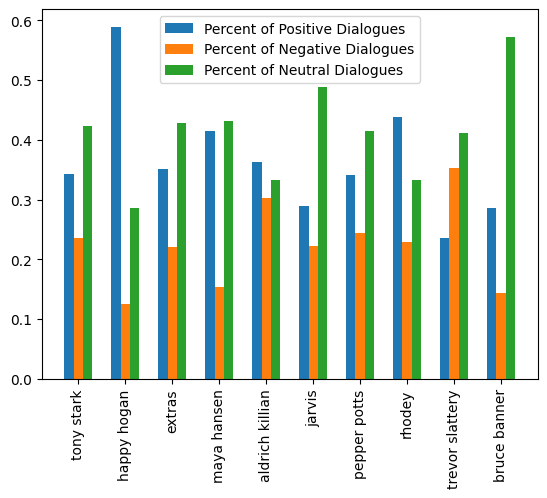

In [48]:
# def create_data_loader(path):
read_data = 'Iron Man 3.txt'
important_chars = ['tony stark','pepper potts','rhodey','aldrich killian','maya hansen','ellen brandt','eric savin','mathew ellis','happy hogan','trevor slattery','jarvis','extras','bruce banner']
char_dialogues, all_dialogues = process_the_script(important_chars,read_data)
sent_dict = {}
for char in char_dialogues:
    sent_dict[char] = compute_sentiment_labels(char_dialogues[char])

plot_sentiment_distribution(sent_dict)
